In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy.stats import pearsonr
from collections import Counter

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

sns.set_palette("Set2")

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

from keras.layers import BatchNormalization

In [2]:
PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/dados/input/"

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

LABELS=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%", 
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

In [3]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")

In [4]:
def categorize(x):
    if x < - 0.9:
        return LABELS[0]
    elif x < - 0.6:
        return LABELS[1]
    elif x < - 0.3:
        return LABELS[2]
    elif x < - 0.1:
        return LABELS[3]
    elif x < 0.1:
        return LABELS[4]
    elif x < 0.3:
        return LABELS[5]
    elif x < 0.6:
        return LABELS[6]
    elif x < 0.9:
        return LABELS[7]
    else:
        return LABELS[8]

In [5]:
def show_delta (y_test, y_pred):
    
    data=(y_pred - y_test)/y_test

    error = pd.DataFrame(data, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(28,6))

    sns.countplot(data=error, x='categoria', order=LABELS)

    plt.show()

In [6]:
def show_predictions_graphs (data):

    plt.figure(figsize=(24,45))

    for state in range(27):

        plt.subplot(9,3,state+1)
        
        plt.yscale('linear')

        plt.title (f"Distribuição do erro do estado {SIGLAS[state]}")

        # pred = y_pred[state]
        # real = y_test[state]

        plt.plot(pd.DataFrame(data[SIGLAS[state]]["y_pred"]), label="Previsão", color="coral")
        plt.plot(pd.DataFrame(data[SIGLAS[state]]["y_test"]), label="Dado Real", linestyle=":",color="darkgreen")

        plt.legend()
    plt.show()

In [7]:
def split_y_state (y):

    if type(y) == np.ndarray:

        return dict(zip([i for i in range(27)], [[y[i] for i in range(s, len(y), 27)] for s in range(27)]))

    return dict(zip([i for i in range(27)], [[y.iloc[i] for i in range(s, y.size, 27)] for s in range(27)]))

# Modelos

In [69]:
x = pd.read_csv("../dados/input/input.csv")
x = x.sort_values(["data", "estados"])
PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/"
y = pd.read_csv(PATH + "target_abs.csv")
y = pd.melt(y,id_vars=["data"], value_vars=SIGLAS, var_name="estados", value_name="consumo")

In [70]:
df = x.copy()

In [71]:
anuais = [ 'pib_pc', 'pib_pmc', 'pib_pcpt', 'pib_cc',
          'populacao', 'idh_l', 'idh_r', 'idh_e', 'desemprego']
mensais = ['incc', 'ipca', 'igp', 'selic', 'nfsp',
           'estoque', 'producao', 'preco_ton', 'preco_saco',
           'preco_kg']

In [72]:
df_sorted = df.sort_values(by=["estados", "data"]).copy()
for estado in df.estados.unique():
    indexes = df_sorted[df_sorted["estados"] == estado].index
    df_sorted.loc[indexes, anuais] = df_sorted.loc[indexes, anuais].shift(12)
    df_sorted.loc[indexes, mensais] = df_sorted.loc[indexes, mensais].shift(1)

In [74]:
x = df_sorted.copy()
x['data'] = pd.to_datetime(x['data'])

In [75]:
PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/"
y = pd.read_csv(PATH + "target_abs.csv")
y = pd.melt(y,id_vars=["data"], value_vars=SIGLAS, var_name="estados", value_name="consumo")
y = y.sort_values(['data', 'estados'])

In [76]:
y['data'] = pd.to_datetime(y['data'], format="%Y%m")

In [77]:
df = pd.merge(x,y, on=['estados', 'data'])

In [78]:
df = df.dropna()

In [80]:
df = df.sort_values(["data", "estados"])
df = pd.get_dummies(data=df, columns=["estados"], drop_first=True)

x=df.copy().drop(['data', 'consumo'], axis=1)
y = df['consumo'].copy()

In [30]:
#x = pd.read_csv("../dados/input/input.csv")
#x=x.sort_values(["data", "estados"])
#x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)
#x=x[(x["data"] >= "1991-01-01") & (x["data"] <= "2018-12-01")]

In [83]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
107/107 [==============================] - 4s 5ms/step - loss: 93046849536.0000 - RMSE: 305035.8125
Epoch 2/100
107/107 [==============================] - 1s 5ms/step - loss: 90990796800.0000 - RMSE: 301646.8125
Epoch 3/100
107/107 [==============================] - 1s 6ms/step - loss: 75397996544.0000 - RMSE: 274586.9688
Epoch 4/100
107/107 [==============================] - 1s 5ms/step - loss: 38521090048.0000 - RMSE: 196267.9062
Epoch 5/100
107/107 [==============================] - 1s 5ms/step - loss: 12010330112.0000 - RMSE: 109591.6484
Epoch 6/100
107/107 [==============================] - 1s 5ms/step - loss: 6220100608.0000 - RMSE: 78867.6172
Epoch 7/100
107/107 [==============================] - 1s 5ms/step - loss: 5024419840.0000 - RMSE: 70883.1406
Epoch 8/100
107/107 [==============================] - 1s 5ms/step - loss: 4248761856.0000 - RMSE: 65182.5273
Epoch 9/100
107/107 [==============================] - 1s 5ms/step - loss: 3926629632.0000 - RMSE: 62662.8242


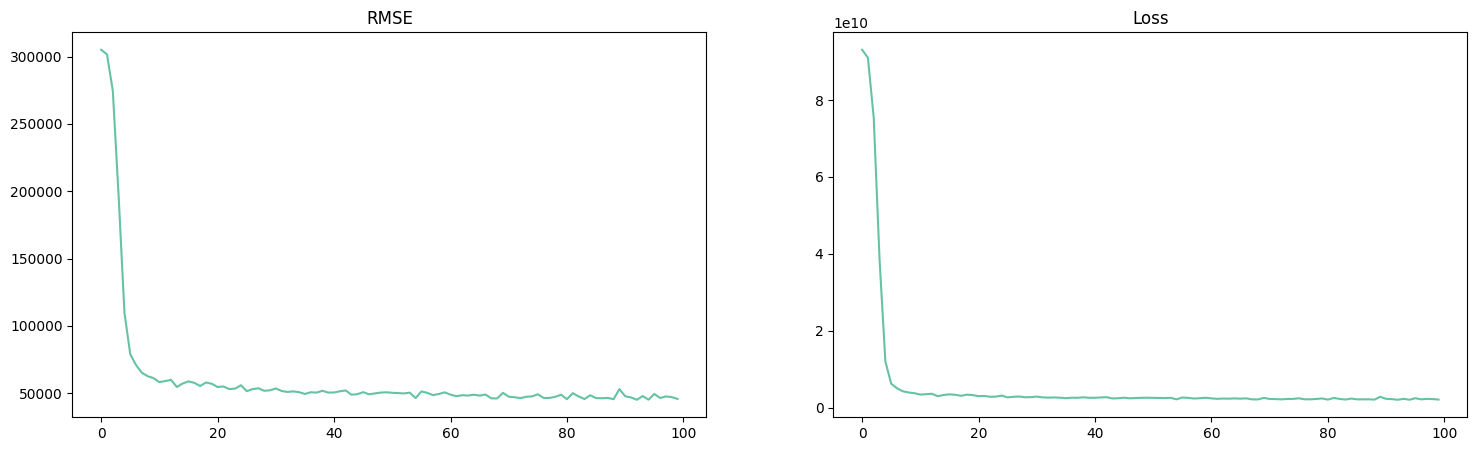

In [84]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [85]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

19/19 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 54305.26915988663
MAE: 37015.61847876869
MAPE: 0.4729360630458572


In [115]:
#anterior
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

43/43 [==============================] - 0s 998us/step
Scores obtidos:
RMSE: 103484.26112881998
MAE: 69888.36819922162
MAPE: 0.9365078835914098


In [86]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
107/107 [==============================] - 2s 6ms/step - loss: 91364818944.0000 - RMSE: 302266.1250
Epoch 2/100
107/107 [==============================] - 1s 6ms/step - loss: 31664574464.0000 - RMSE: 177945.4219
Epoch 3/100
107/107 [==============================] - 1s 6ms/step - loss: 4129798656.0000 - RMSE: 64263.5078
Epoch 4/100
107/107 [==============================] - 1s 6ms/step - loss: 3319432960.0000 - RMSE: 57614.5195
Epoch 5/100
107/107 [==============================] - 1s 6ms/step - loss: 3267258112.0000 - RMSE: 57159.9336
Epoch 6/100
107/107 [==============================] - 1s 6ms/step - loss: 2850641408.0000 - RMSE: 53391.3984
Epoch 7/100
107/107 [==============================] - 1s 6ms/step - loss: 3007347712.0000 - RMSE: 54839.2891
Epoch 8/100
107/107 [==============================] - 1s 6ms/step - loss: 2641283328.0000 - RMSE: 51393.4180
Epoch 9/100
107/107 [==============================] - 1s 6ms/step - loss: 2615054080.0000 - RMSE: 51137.5977
Epoch 

In [87]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

19/19 [==============================] - 0s 6ms/step
Scores obtidos:
RMSE: 56617.29641268193
MAE: 38176.73543916113
MAPE: 0.4951751309118708


In [88]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=500)

Epoch 1/500
107/107 [==============================] - 2s 6ms/step - loss: 90107174912.0000 - RMSE: 300178.5625
Epoch 2/500
107/107 [==============================] - 1s 6ms/step - loss: 22981662720.0000 - RMSE: 151597.0469
Epoch 3/500
107/107 [==============================] - 1s 6ms/step - loss: 3456722688.0000 - RMSE: 58793.8984
Epoch 4/500
107/107 [==============================] - 1s 5ms/step - loss: 2938858240.0000 - RMSE: 54211.2383
Epoch 5/500
107/107 [==============================] - 1s 6ms/step - loss: 2750549760.0000 - RMSE: 52445.6836
Epoch 6/500
107/107 [==============================] - 1s 7ms/step - loss: 2614321152.0000 - RMSE: 51130.4336
Epoch 7/500
107/107 [==============================] - 1s 6ms/step - loss: 2402177792.0000 - RMSE: 49012.0156
Epoch 8/500
107/107 [==============================] - 1s 6ms/step - loss: 2392427264.0000 - RMSE: 48912.4453
Epoch 9/500
107/107 [==============================] - 1s 6ms/step - loss: 2211638784.0000 - RMSE: 47028.0625
Epoch 

In [89]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

19/19 [==============================] - 0s 6ms/step
Scores obtidos:
RMSE: 53292.65343498221
MAE: 40886.24049554869
MAPE: 0.3786323184489373


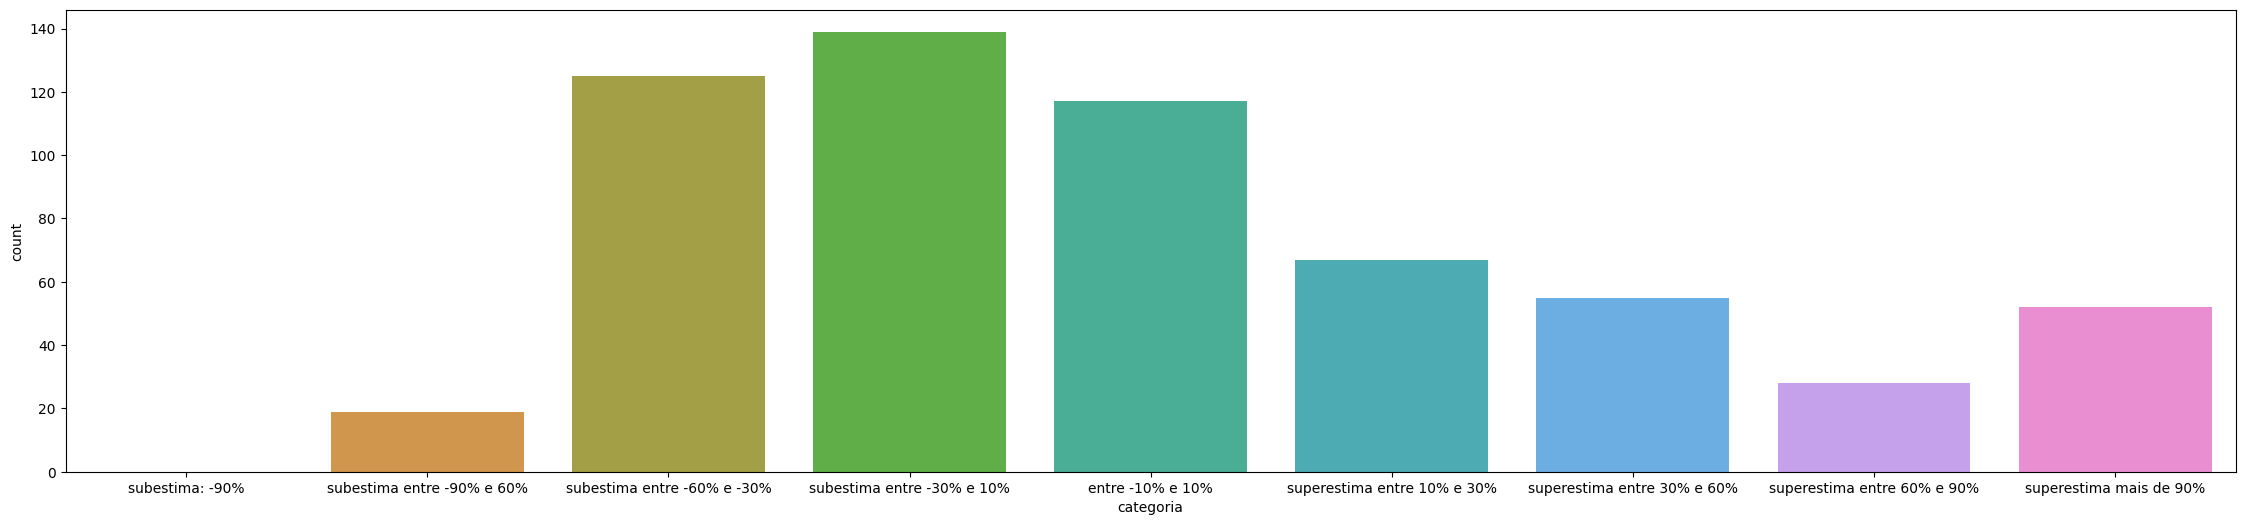

In [90]:
show_delta(np.array(y_test), y_pred.flatten())

In [91]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
107/107 [==============================] - 2s 5ms/step - loss: 93021642752.0000 - RMSE: 304994.5000
Epoch 2/100
107/107 [==============================] - 1s 6ms/step - loss: 90120667136.0000 - RMSE: 300201.0312
Epoch 3/100
107/107 [==============================] - 1s 6ms/step - loss: 73246138368.0000 - RMSE: 270640.2500
Epoch 4/100
107/107 [==============================] - 1s 5ms/step - loss: 49011765248.0000 - RMSE: 221386.0156
Epoch 5/100
107/107 [==============================] - 0s 3ms/step - loss: 40944865280.0000 - RMSE: 202348.3750
Epoch 6/100
107/107 [==============================] - 0s 3ms/step - loss: 36682641408.0000 - RMSE: 191527.1250
Epoch 7/100
107/107 [==============================] - 0s 4ms/step - loss: 31759243264.0000 - RMSE: 178211.2344
Epoch 8/100
107/107 [==============================] - 1s 5ms/step - loss: 26178985984.0000 - RMSE: 161799.2188
Epoch 9/100
107/107 [==============================] - 1s 5ms/step - loss: 20397010944.0000 - RMSE: 1428

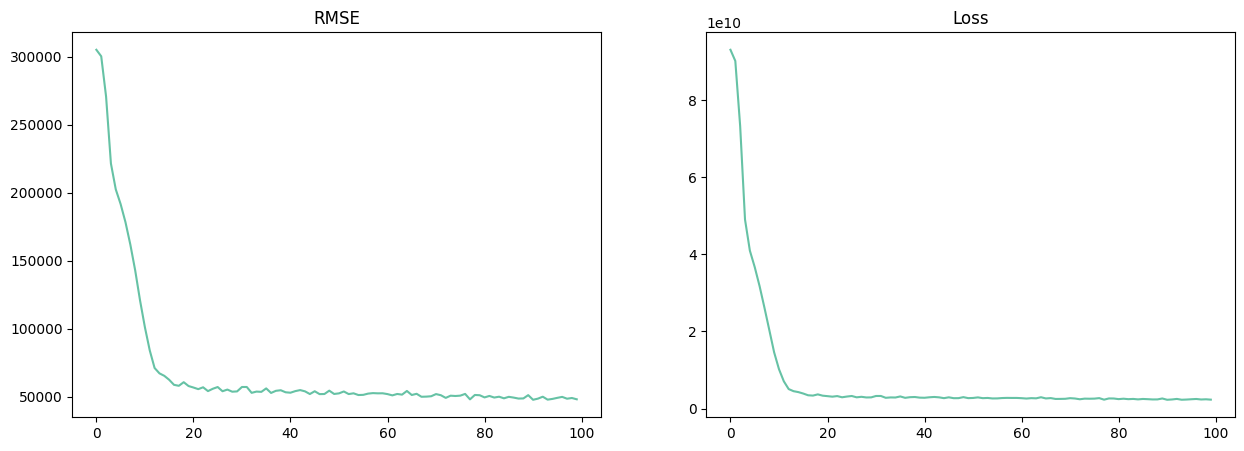

In [93]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [92]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

19/19 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 72772.33832606592
MAE: 41840.932029952244
MAPE: 0.36661726382056464


In [119]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

43/43 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 112537.81292023466
MAE: 69454.93993100202
MAPE: 0.8291124474729308


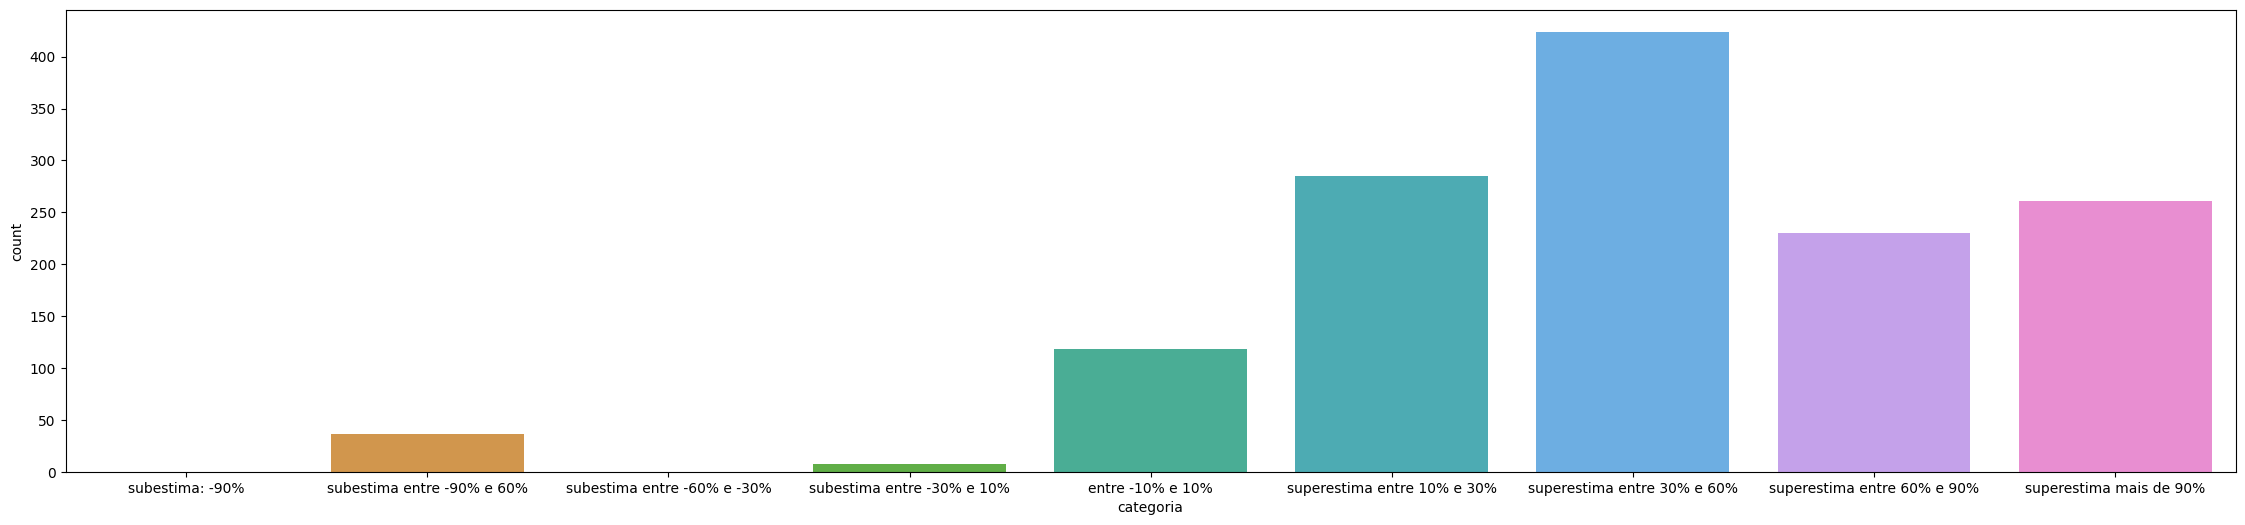

In [120]:
show_delta(np.array(y_test), y_pred.flatten())

In [121]:
len(y_test) % 27

11

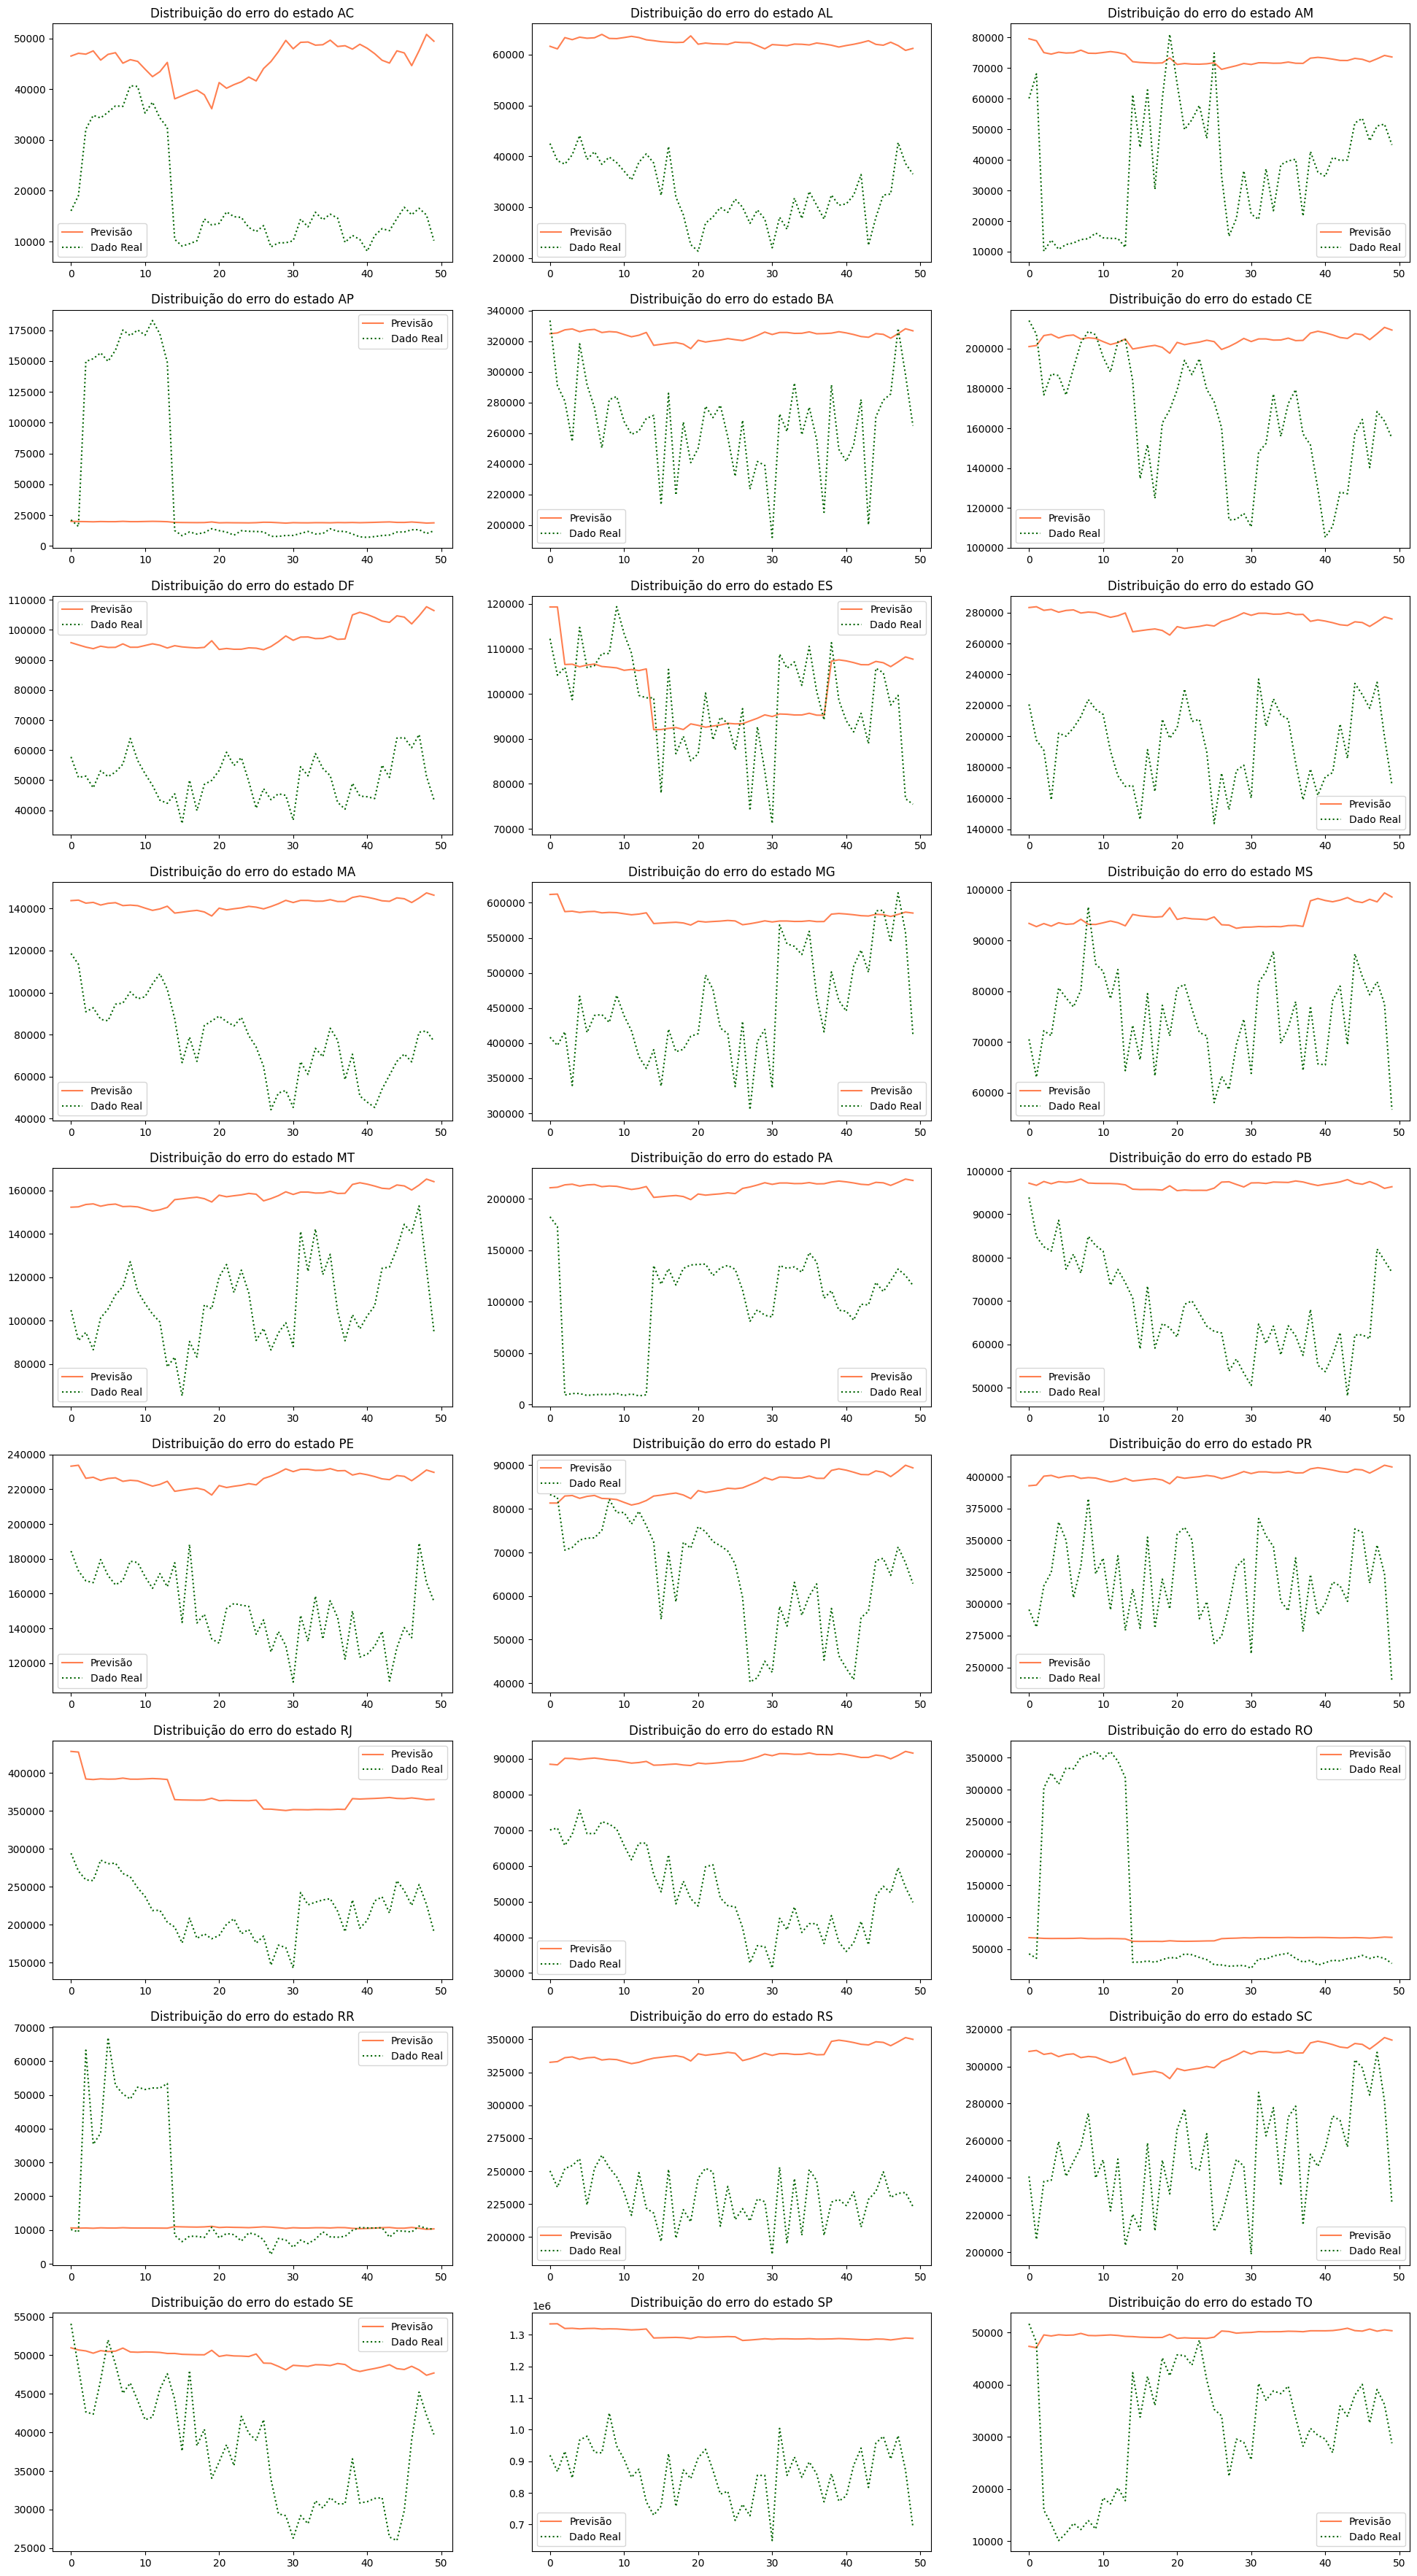

In [122]:
y_pred = y_pred[11:]
y_test = y_test[11:]

y_pred_state = split_y_state(y_pred)
y_test_state = split_y_state(y_test)

pred = {}

for i in range(27):
    pred[SIGLAS[i]] = {"y_test":y_test_state[i],
                       "y_pred":y_pred_state[i]}
show_predictions_graphs(pred)

In [122]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, shuffle=False)

Epoch 1/100
107/107 [==============================] - 2s 6ms/step - loss: 93003595776.0000 - RMSE: 304964.9062
Epoch 2/100
107/107 [==============================] - 1s 5ms/step - loss: 89175728128.0000 - RMSE: 298623.0625
Epoch 3/100
107/107 [==============================] - 1s 6ms/step - loss: 63989407744.0000 - RMSE: 252961.2812
Epoch 4/100
107/107 [==============================] - 1s 6ms/step - loss: 21506660352.0000 - RMSE: 146651.5000
Epoch 5/100
107/107 [==============================] - 1s 6ms/step - loss: 6952252416.0000 - RMSE: 83380.1719
Epoch 6/100
107/107 [==============================] - 1s 5ms/step - loss: 5102642688.0000 - RMSE: 71432.7812
Epoch 7/100
107/107 [==============================] - 1s 5ms/step - loss: 4309890560.0000 - RMSE: 65649.7578
Epoch 8/100
107/107 [==============================] - 1s 6ms/step - loss: 3803944960.0000 - RMSE: 61676.1289
Epoch 9/100
107/107 [==============================] - 1s 5ms/step - loss: 3624953088.0000 - RMSE: 60207.5820
Ep

In [123]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

19/19 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 53760.4420092747
MAE: 36290.99895530523
MAPE: 0.44659120666836033


In [94]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = PowerTransformer()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dense(units=16, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
107/107 [==============================] - 2s 5ms/step - loss: 92911771648.0000 - RMSE: 304814.3125
Epoch 2/100
107/107 [==============================] - 1s 5ms/step - loss: 75438039040.0000 - RMSE: 274659.8750
Epoch 3/100
107/107 [==============================] - 1s 6ms/step - loss: 18953697280.0000 - RMSE: 137672.4219
Epoch 4/100
107/107 [==============================] - 1s 5ms/step - loss: 8636552192.0000 - RMSE: 92933.0547
Epoch 5/100
107/107 [==============================] - 1s 5ms/step - loss: 5385775104.0000 - RMSE: 73387.8438
Epoch 6/100
107/107 [==============================] - 1s 5ms/step - loss: 5074684416.0000 - RMSE: 71236.8203
Epoch 7/100
107/107 [==============================] - 1s 5ms/step - loss: 4116495104.0000 - RMSE: 64159.9180
Epoch 8/100
107/107 [==============================] - 1s 5ms/step - loss: 3945532160.0000 - RMSE: 62813.4727
Epoch 9/100
107/107 [==============================] - 1s 5ms/step - loss: 3447708928.0000 - RMSE: 58717.1953
Epoc

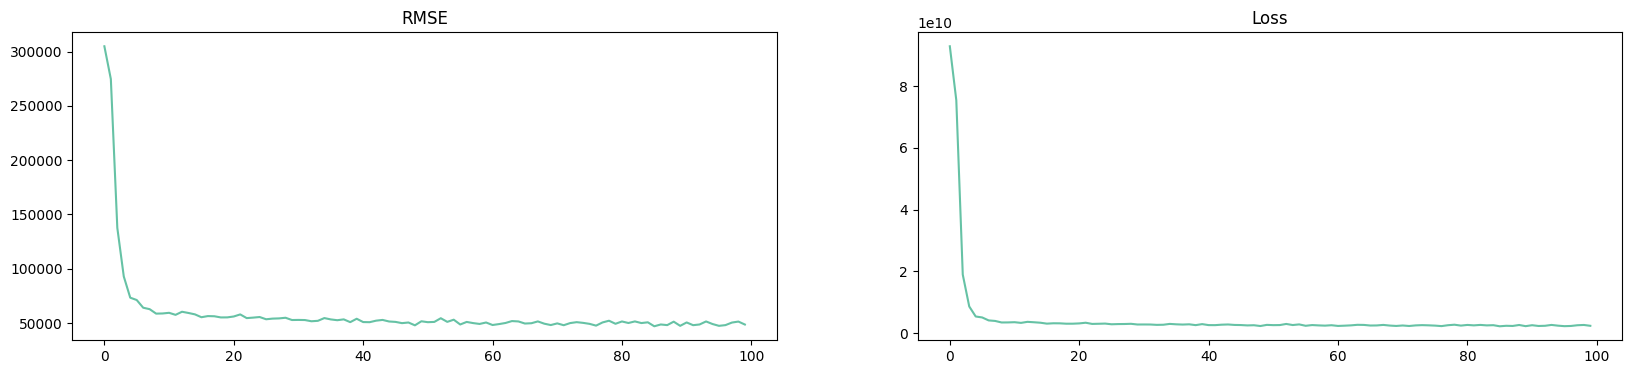

In [95]:
plt.figure(figsize=(20,4))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [125]:
show_scores(score_regression_metrics(y_train, model.predict(x_train)))
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

241/241 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 27919.783739573424
MAE: 14009.315700548126
MAPE: 3093401817938485.0
43/43 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 91937.0683363055
MAE: 62986.67700966661
MAPE: 0.8480527244544965


In [96]:
show_scores(score_regression_metrics(y_train, model.predict(x_train)))
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

107/107 [==============================] - 1s 4ms/step
Scores obtidos:
RMSE: 34134.2315827132
MAE: 19359.127663182477
MAPE: 0.16758074684348045
19/19 [==============================] - 0s 4ms/step
Scores obtidos:
RMSE: 58592.91338415099
MAE: 38473.60676975187
MAPE: 0.3593707699063115


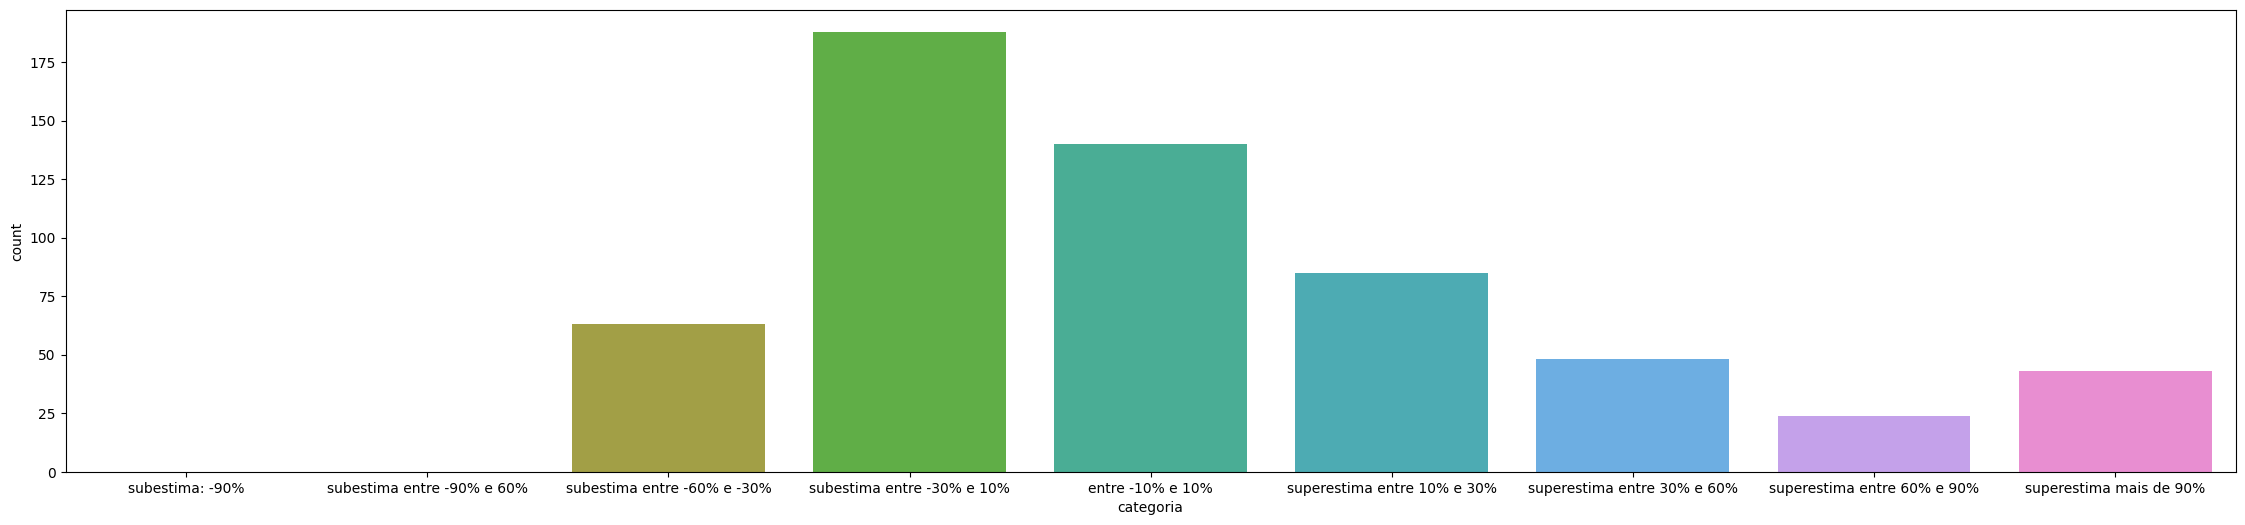

In [98]:
show_delta(np.array(y_test), y_pred.flatten())

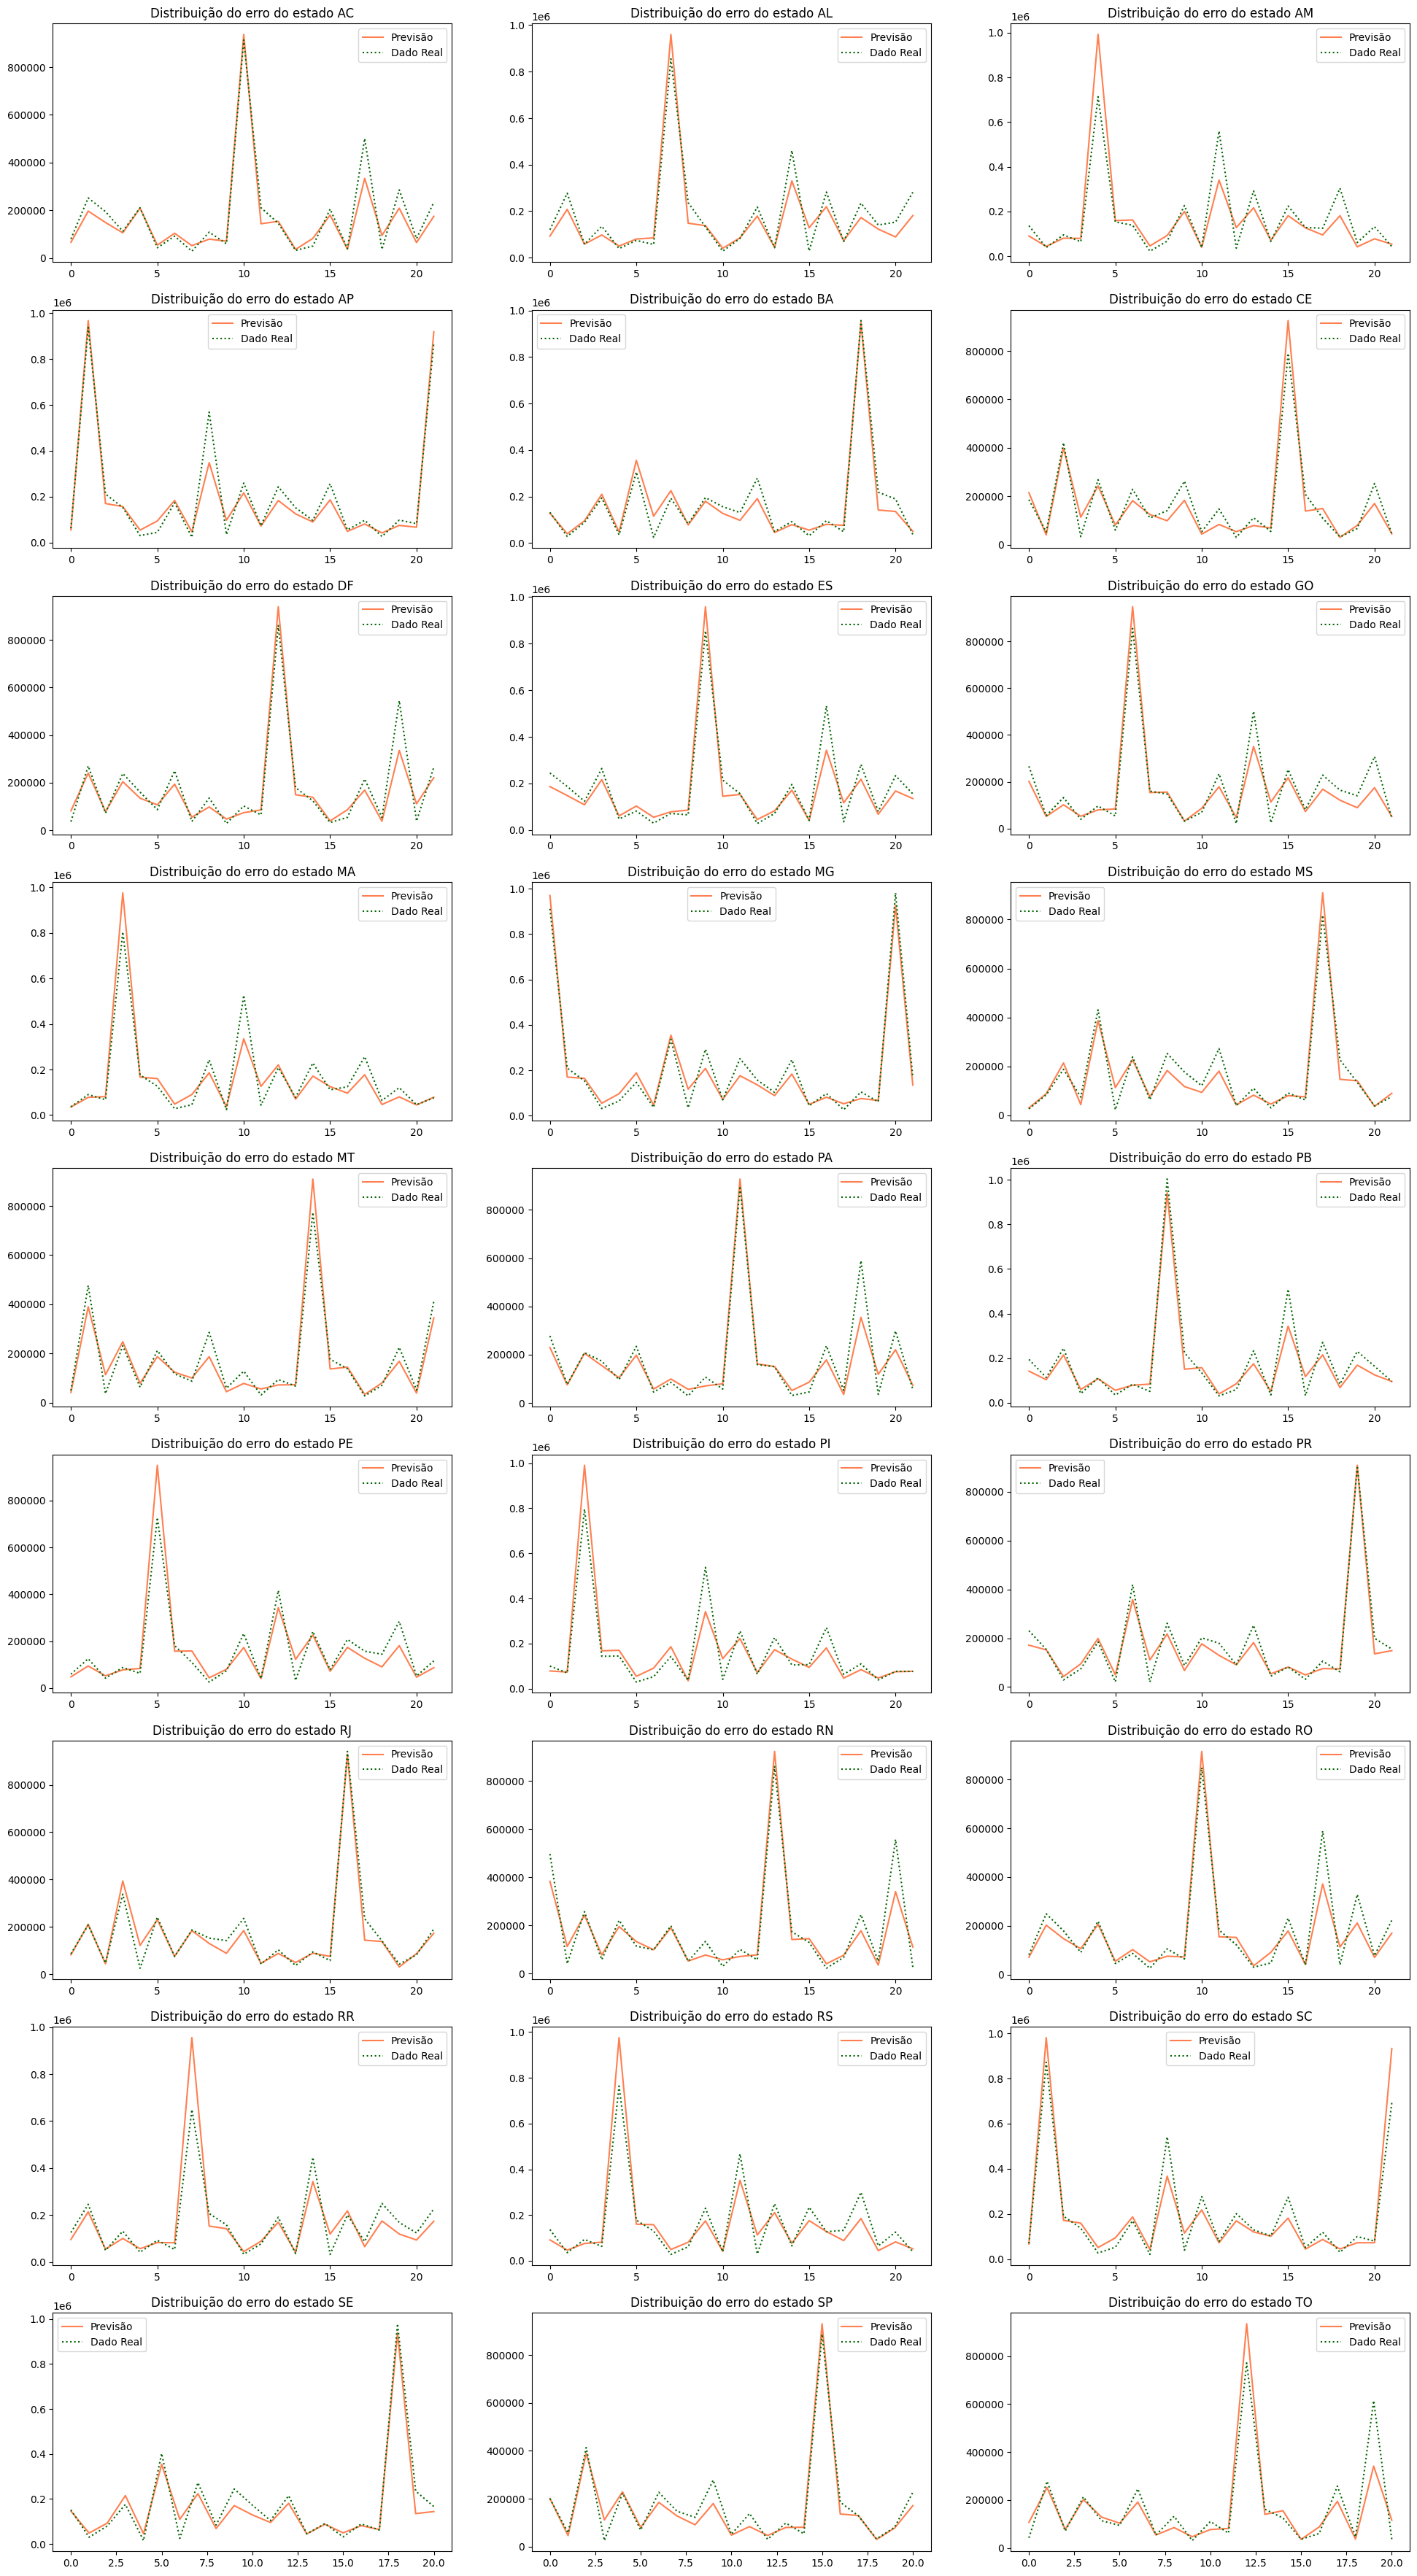

In [97]:
y_pred = y_pred[11:]
y_test = y_test[11:]

y_pred_state = split_y_state(y_pred)
y_test_state = split_y_state(y_test)

pred = {}

for i in range(27):
    pred[SIGLAS[i]] = {"y_test":y_test_state[i],
                       "y_pred":y_pred_state[i]}
show_predictions_graphs(pred)

## LSTM

In [99]:
# n_steps -> timestep no tempo .. pegar contexto
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [100]:
class StandardScaler3DShape:
    def __init__(self, scaler=StandardScaler):
        self.scaler = scaler() #StandardScaler()

    def fit_transform(self, X, y=None):
        X_new = self.scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new

    def fit(self, X, y=None):
        X_new = X.reshape(-1, X.shape[-1])
        self.scaler.fit(X_new)
        return self

    def transform(self, X, y=None):
        X_new = self.scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new

In [102]:
df = x.copy()
df["consumo"] = y

In [162]:
x = pd.read_csv("../dados/input/input.csv")
x=x.sort_values(["data", "estados"])
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)
x=x[(x["data"] >= "1999-01-01") & (x["data"] <= "2018-12-01")]
#x = x.drop(["data"], axis=1)

PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/"
y = pd.read_csv(PATH + "target_abs.csv")
y = pd.melt(y,id_vars=["data"], value_vars=SIGLAS, var_name="estados", value_name="consumo")
y = y.sort_values(['data', 'estados'])
y=y[(y["data"] > 199912)]

df = x.copy()
df["consumo"] = y["consumo"].values

In [104]:
df_train, df_test = train_test_split(df, test_size=0.15, shuffle=False)

timesteps=3
scaler = StandardScaler3DShape()
x_train,y_train = split_sequences(df_train.values, timesteps)
x_test,y_test = split_sequences(df_test.values, timesteps)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [105]:
model = Sequential()
model.add(LSTM(units=32, activation="relu")),
model.add(Dense(units=16, activation="relu")),
model.add(Dense(units=8, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])

In [106]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32) 

Epoch 1/100
107/107 [==============================] - 5s 8ms/step - loss: 93139574784.0000 - RMSE: 305187.7812
Epoch 2/100
107/107 [==============================] - 1s 8ms/step - loss: 89757138944.0000 - RMSE: 299594.9688
Epoch 3/100
107/107 [==============================] - 1s 8ms/step - loss: 41250557952.0000 - RMSE: 203102.3281
Epoch 4/100
107/107 [==============================] - 1s 8ms/step - loss: 11922177024.0000 - RMSE: 109188.7188
Epoch 5/100
107/107 [==============================] - 1s 8ms/step - loss: 6764027904.0000 - RMSE: 82243.7109
Epoch 6/100
107/107 [==============================] - 1s 10ms/step - loss: 5376754688.0000 - RMSE: 73326.3594
Epoch 7/100
107/107 [==============================] - 1s 9ms/step - loss: 5712339968.0000 - RMSE: 75580.0234
Epoch 8/100
107/107 [==============================] - 1s 8ms/step - loss: 6147453440.0000 - RMSE: 78405.6953
Epoch 9/100
107/107 [==============================] - 1s 9ms/step - loss: 4738077184.0000 - RMSE: 68833.6953
E

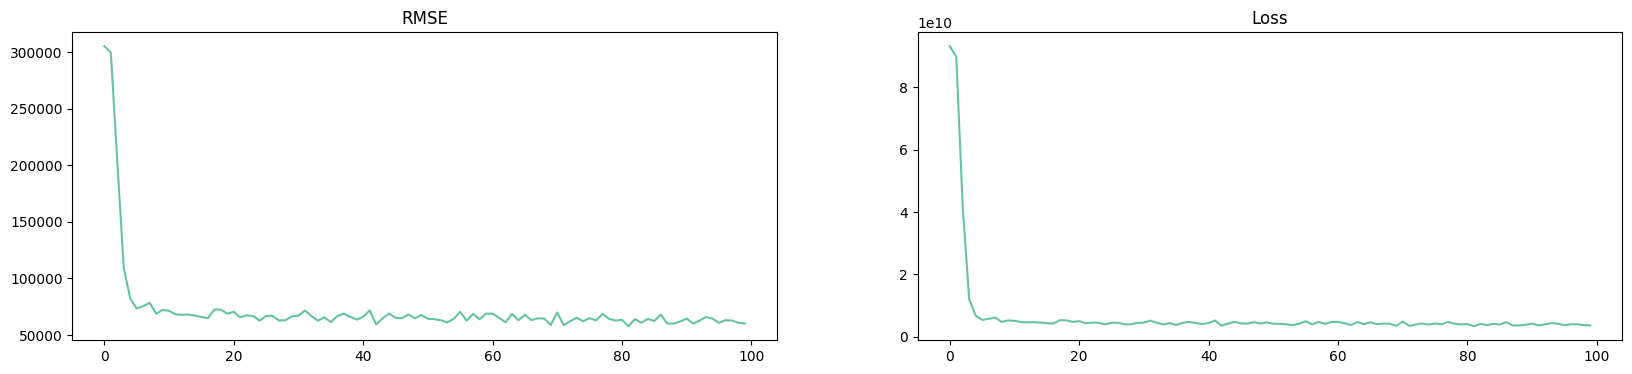

In [107]:
plt.figure(figsize=(20,4))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [108]:
show_scores(score_regression_metrics(y_train, model.predict(x_train)))
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

107/107 [==============================] - 2s 5ms/step
Scores obtidos:
RMSE: 25758.43242440332
MAE: 15281.032950758548
MAPE: 0.13904536574472973
19/19 [==============================] - 0s 4ms/step
Scores obtidos:
RMSE: 47107.85137072632
MAE: 32885.255271809896
MAPE: 0.29119117798902666


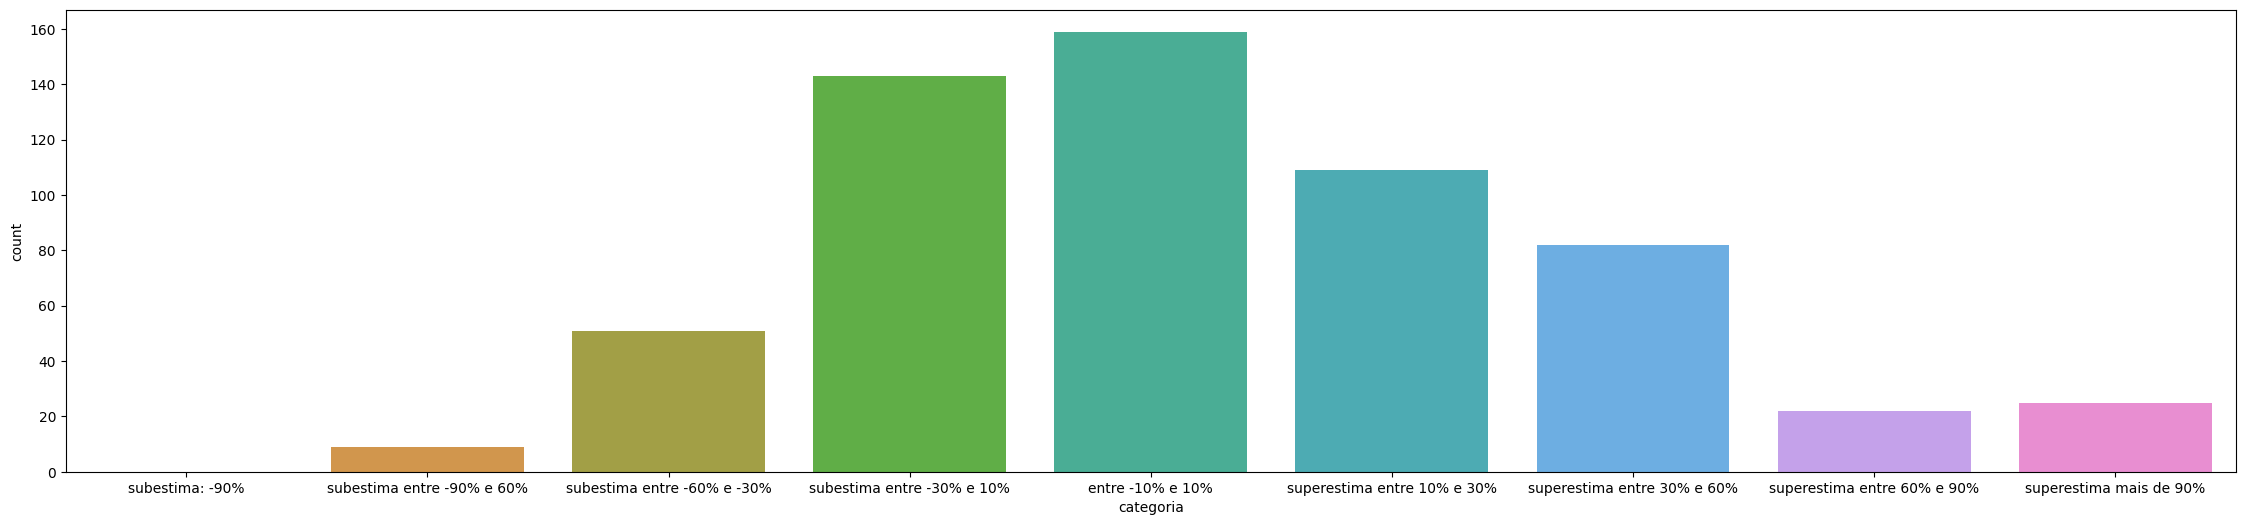

In [109]:
show_delta(np.array(y_test), y_pred.flatten())

In [110]:
model = Sequential()
model.add(LSTM(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")])

In [111]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32) 

Epoch 1/100
107/107 [==============================] - 5s 11ms/step - loss: 87366664192.0000 - RMSE: 295578.5312
Epoch 2/100
107/107 [==============================] - 1s 11ms/step - loss: 12240495616.0000 - RMSE: 110636.7734
Epoch 3/100
107/107 [==============================] - 1s 11ms/step - loss: 2902239744.0000 - RMSE: 53872.4414
Epoch 4/100
107/107 [==============================] - 2s 14ms/step - loss: 2738014720.0000 - RMSE: 52326.0430
Epoch 5/100
107/107 [==============================] - 1s 13ms/step - loss: 2403208192.0000 - RMSE: 49022.5273
Epoch 6/100
107/107 [==============================] - 2s 15ms/step - loss: 2228582144.0000 - RMSE: 47207.8594
Epoch 7/100
107/107 [==============================] - 1s 12ms/step - loss: 2351543808.0000 - RMSE: 48492.7188
Epoch 8/100
107/107 [==============================] - 1s 12ms/step - loss: 2201574656.0000 - RMSE: 46920.9414
Epoch 9/100
107/107 [==============================] - 2s 15ms/step - loss: 2149399808.0000 - RMSE: 46361.62

In [112]:
show_scores(score_regression_metrics(y_train, model.predict(x_train)))
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

107/107 [==============================] - 1s 4ms/step
Scores obtidos:
RMSE: 20944.19806506762
MAE: 12795.140843438143
MAPE: 0.11035492600237029
19/19 [==============================] - 0s 4ms/step
Scores obtidos:
RMSE: 45106.080878953464
MAE: 32407.54757486979
MAPE: 0.3221364519393746


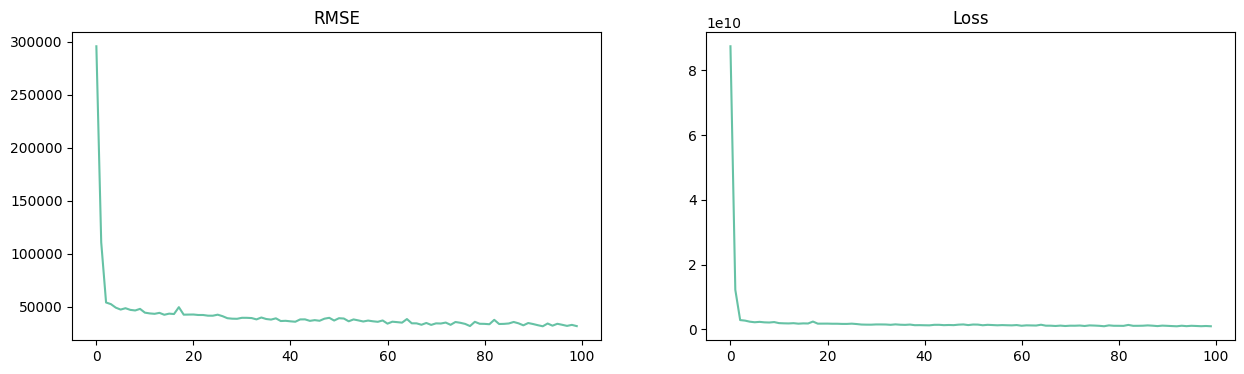

In [113]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [ ]:
## show_scores(score_regression_metrics(y_train, model.predict(x_train)))
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

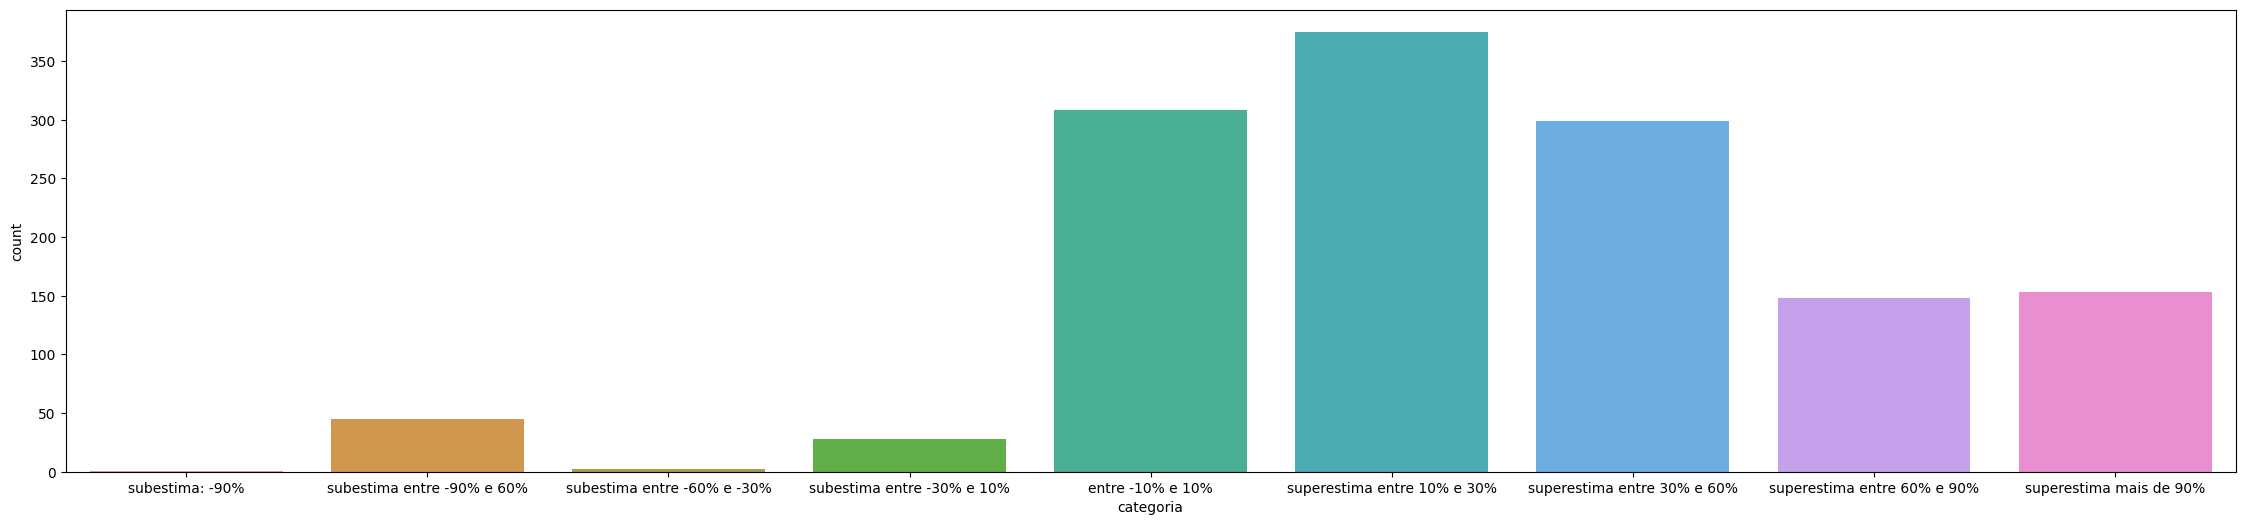

In [147]:
show_delta(np.array(y_test), y_pred.flatten())

In [151]:
y = pd.read_csv(PATH + "target_abs.csv")
y = pd.melt(y,id_vars=["data"], value_vars=SIGLAS, var_name="estados", value_name="consumo")
y = y.sort_values(['data', 'estados'])

In [154]:
y[y["consumo"] == 0]

,data,estados,consumo
3,199004,AC,0.0
7583,199112,RR,0.0
7585,199202,RR,0.0
7588,199205,RR,0.0
7608,199401,RR,0.0
7609,199402,RR,0.0
7620,199501,RR,0.0


# Regressão Linear

In [120]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)

regr = LinearRegression()

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

regr.fit(x_train, y_train)

print(f"Score: {regr.score(x_test, y_test)}")

# fazendo previsão 
y_pred = regr.predict(x_test)

Score: 0.9693633126072358


In [117]:
# 20%
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Scores obtidos:
RMSE: 62489.35596829383
MAE: 46026.41228518797
MAPE: 0.6359131546778707


In [119]:
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Scores obtidos:
RMSE: 60787.44834950966
MAE: 41518.67643352291
MAPE: 0.455684013611409


In [121]:
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Scores obtidos:
RMSE: 41826.745811345674
MAE: 24789.960844012385
MAPE: 0.2570704341727095
